## Train / Dev split

In [1]:
import pandas as pd
import numpy as np

benign_urls = pd.read_csv('datasets/ISCXURL2016/Benign_list_big_final.csv', names=['URL'])
malicious_urls = pd.read_csv('datasets/ISCXURL2016/phishing_dataset.csv', names=['URL'])

In [2]:
benign_urls.shape[0], malicious_urls.shape[0]

(35378, 9965)

In [3]:
def split(data, ratio=0.5):
    data = data.sample(frac=1)
    msk = np.random.rand(len(data)) < ratio
    split_1 = data[msk]
    split_2 = data[~msk]
    
    return split_1, split_2

In [4]:
benign_test, benign_train = split(benign_urls, malicious_urls.shape[0]/benign_urls.shape[0])
benign_train, benign_dev = split(benign_train, 0.8)

benign_train, benign_dev = split(benign_urls, 0.8)

In [5]:
benign_train.shape[0], benign_dev.shape[0], benign_test.shape[0]

(28280, 7098, 10013)

In [14]:
test.shape[0]

19978

In [13]:
benign_train.to_csv('datasets/benign_train.csv', index=False)
benign_dev.to_csv('datasets/benign_dev.csv', index=False)

benign_test['label'] = 0
malicious_urls['label'] = 1
test = pd.concat([benign_test, malicious_urls])
test.to_csv('datasets/test.csv', index=False)

# train = pd.read_csv('/content/drive/MyDrive/network security final project/datasets/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/network security final project/datasets/test.csv')

In [36]:
for url in benign_train.URL:
    print(url)
    break

http://atwiki.jp/wiki/%E3%82%B9%E3%82%AB%E3%83%AB%E3%83%96%E3%83%AA%E3%82%B6%E3%83%BC%E3%83%89


## Train Tokenizer

In [1]:
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.models import BPE
from tokenizers.normalizers import Lowercase, NFKC, Sequence
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.processors import TemplateProcessing

In [2]:
# First we create an empty Byte-Pair Encoding model (i.e. not trained model)
tokenizer = Tokenizer(BPE())

# Then we enable lower-casing and unicode-normalization
# The Sequence normalizer allows us to combine multiple Normalizer that will be
# executed in order.
tokenizer.normalizer = Sequence([
    NFKC(),
    Lowercase()
])

# Our tokenizer also needs a pre-tokenizer responsible for converting the input to a ByteLevel representation.
tokenizer.pre_tokenizer = ByteLevel()

# And finally, let's plug a decoder so we can recover from a tokenized input to the original one
tokenizer.decoder = ByteLevelDecoder()

tokenizer.enable_padding()

In [5]:
from tokenizers.trainers import BpeTrainer

def url_iterator(filename='datasets/train.csv'):
    df = pd.read_csv(filename)
    for url in df.URL:
        yield url

# We initialize our trainer, giving him the details about the vocabulary we want to generate
trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[SOS]", "[EOS]"], show_progress=True, initial_alphabet=ByteLevel.alphabet())
tokenizer.train_from_iterator(url_iterator('datasets/benign_train.csv'), trainer=trainer)

print("Trained vocab size: {}".format(tokenizer.get_vocab_size()))

Trained vocab size: 30000


In [68]:
# tokenizer.post_processor = TemplateProcessing(
#     single="[SOS] $A [EOS]",
#     pair="$A $B",
#     special_tokens=[
#         ("[SOS]", tokenizer.token_to_id("[SOS]")),
#         ("[EOS]", tokenizer.token_to_id("[EOS]"))
#     ])

In [64]:
tokenizer.model.save('tokenizer')

['tokenizer/vocab.json', 'tokenizer/merges.txt']

In [ ]:
# tokenizer.model = BPE('tokenizer/vocab.json', 'tokenizer/merges.txt')
encoding = tokenizer.encode(train.domain[3])
print('Encoded string:', encoding.tokens)

decoded = tokenizer.decode(encoding.ids)
print("Decoded string:", decoded)

Encoded string: ['Ġmail', '.', 'prin', 'ta', 'kid', '.', 'com', '/', 'www', '.', 'online', '.', 'americanexpress', '.', 'com', '/', 'index', '.', 'html']
Decoded string:  mail.printakid.com/www.online.americanexpress.com/index.html


## Prepare Data

In [27]:
import os
from functools import partial
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset

class UrlDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename).URL.tolist()
     
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    
class UrlTestDataset(Dataset):
    def __init__(self, filename):
        df = pd.read_csv(filename)
        self.data = df.URL.tolist()
        self.label = df.label.tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

class UrlTestDataset2(Dataset):
    def __init__(self, filename):
        df = pd.read_csv(filename)
        self.data = df.domain.tolist()
        self.label = df.label.tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    

def get_dataset(data_dir='datasets', data_split='train'):
    if data_split == 'train':
        return UrlDataset(os.path.join(data_dir, 'benign_train.csv'))
    elif data_split == 'dev':
        return UrlDataset(os.path.join(data_dir, 'benign_dev.csv'))
    elif data_split == 'test1':
        return UrlTestDataset(os.path.join(data_dir, 'test.csv'))
    elif data_split == 'test2':
        return UrlTestDataset2(os.path.join(data_dir, 'urlset.csv'))
    else:
        raise ExceptionError('Data split error')
        
def collate(examples):
    inputs = ['[SOS]' + e for e in examples]
    inputs = torch.tensor([ex.ids for ex in tokenizer.encode_batch(inputs)])
    targets = [e + '[EOS]' for e in examples]
    targets = torch.tensor([ex.ids for ex in tokenizer.encode_batch(targets)])
    return inputs, targets

def test_collate(examples):
    labels = [ex[1] for ex in examples]
    examples = [ex[0] for ex in examples]
    
    # inputs = ['[SOS] http://' + e for e in examples]
    inputs = ['[SOS]' + e for e in examples]
    inputs = torch.tensor([ex.ids for ex in tokenizer.encode_batch(inputs)])
    # targets = ['http://' + e + '[EOS]' for e in examples]
    targets = [e + '[EOS]' for e in examples]
    targets = torch.tensor([ex.ids for ex in tokenizer.encode_batch(targets)])
    return inputs, targets, labels

def test_collate_2(examples):
    labels = [ex[1] for ex in examples]
    examples = [ex[0] for ex in examples]
    
    inputs = ['[SOS] http://' + e for e in examples]
    inputs = torch.tensor([ex.ids for ex in tokenizer.encode_batch(inputs)])
    targets = ['http://' + e + '[EOS]' for e in examples]
    targets = torch.tensor([ex.ids for ex in tokenizer.encode_batch(targets)])
    return inputs, targets, labels

In [28]:
train_dataset = get_dataset(data_dir='datasets')
dev_dataset = get_dataset(data_dir='datasets', data_split='dev')
test_dataset = get_dataset(data_dir='datasets', data_split='test1')
test_dataset_2 = get_dataset(data_dir='datasets', data_split='test2')

In [8]:
# train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate, shuffle=True, pin_memory=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, collate_fn=collate, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=test_collate, shuffle=False)

# for i, data in enumerate(train_dataloader):
#     print(data)
#     break
#     if i == 5:
#         break

## VAE Model

In [9]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def fold(f, l, a):
    return a if (len(l) == 0) else fold(f, l[1:], f(a, l[0]))

class Highway(nn.Module):
    def __init__(self, size, num_layers, f):

        super(Highway, self).__init__()

        self.num_layers = num_layers

        self.nonlinear = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.nonlinear):
            self._add_to_parameters(module.parameters(), 'nonlinear_module_{}'.format(i))

        self.linear = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.linear):
            self._add_to_parameters(module.parameters(), 'linear_module_{}'.format(i))

        self.gate = [nn.Linear(size, size) for _ in range(num_layers)]
        for i, module in enumerate(self.gate):
            self._add_to_parameters(module.parameters(), 'gate_module_{}'.format(i))

        self.f = f

    def forward(self, x):
        """
        :param x: tensor with shape of [batch_size, size]
        :return: tensor with shape of [batch_size, size]
        applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
        """

        for layer in range(self.num_layers):
            gate = torch.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

    def _add_to_parameters(self, parameters, name):
        for i, parameter in enumerate(parameters):
            self.register_parameter(name='{}-{}'.format(name, i), param=parameter)

In [11]:
class VAE(nn.Module):
    def __init__(self, vocab_size, embed_size, encoder_hidden_size, decoder_hidden_size,
                 dropout_rate, latent_size, encoder_num_layers, decoder_num_layers, word_dropout, sos_idx, unk_idx, pad_idx):
        super().__init__()
        
        self.latent_size = latent_size
        self.word_dropout_rate = word_dropout
        self.encoder_num_layers = encoder_num_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.sos_idx = sos_idx
        self.unk_idx = unk_idx
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.embedding_dropout = nn.Dropout(dropout_rate)
        
        self.kernels = [(1, 25), (2, 50), (3, 75), (4, 100), (5, 125), (6, 150)]
        self.sum_depth = fold(lambda x, y: x + y, [depth for _, depth in self.kernels], 0)
        
        self.highway = Highway(embed_size, 2, F.relu)
        self.encoder = nn.LSTM(embed_size, encoder_hidden_size, num_layers=encoder_num_layers, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(latent_size+embed_size, decoder_hidden_size, num_layers=decoder_num_layers, batch_first=True)
        
        self.mu = nn.Linear(encoder_hidden_size*2, latent_size)
        self.logvar = nn.Linear(encoder_hidden_size*2, latent_size)
        self.fc = nn.Linear(decoder_hidden_size, vocab_size)
        
    def encode(self, encoder_input, batch_size, seq_lens):
        packed = pack_padded_sequence(encoder_input, seq_lens, batch_first=True, enforce_sorted=False)
        encoded_output, (_, final_state) = self.encoder(packed)

        final_state = final_state.view(self.encoder_num_layers, 2, batch_size, self.encoder_hidden_size)
        final_state = final_state[-1]
        h1, h2 = final_state[0], final_state[1]
        final_state = torch.cat([h1, h2], 1)
        
        return final_state
    
    def reparameterize(self, batch_size, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            z = Variable(torch.randn([batch_size, self.latent_size])).to(device)
            return z*std + mu
        else:
            return mu
        
    def decode(self, decoder_input, z, batch_size, seq_len):
        decoder_input = self.embedding(decoder_input)
        decoder_input = self.embedding_dropout(decoder_input)
        
        z = torch.cat([z]*seq_len, 1).view(batch_size, seq_len, self.latent_size)
        decoder_input = torch.cat([decoder_input, z], 2)
        decoded_output, hidden = self.decoder(decoder_input)
        
        return self.fc(decoded_output)
    
    def forward(self, inputs):
        
        embeds = self.embedding(inputs)
        embeds = self.embedding_dropout(embeds)
        [batch_size, seq_len, embed_size] = embeds.size()
        
        encoder_input = embeds.view(-1, embed_size)
        encoder_input = self.highway(encoder_input)
        encoder_input = encoder_input.view(batch_size, seq_len, embed_size)
        
        orig_seq_len = [len([w for w in example if w != 0]) for example in inputs]
        hidden = self.encode(encoder_input, batch_size, orig_seq_len).squeeze()
        
        mu = self.mu(hidden)
        logvar = self.logvar(hidden)
        z = self.reparameterize(batch_size, mu, logvar)
        
        if self.word_dropout_rate > 0:
            # randomly replace decoder input with <unk>
            prob = torch.rand(inputs.size()).to(device)
            prob[(inputs.data - self.sos_idx) * (inputs.data - self.pad_idx) == 0] = 1
            decoder_input = inputs.clone()
            decoder_input[prob < self.word_dropout_rate] = self.unk_idx

        decoder_output = self.decode(decoder_input, z, batch_size, seq_len)
        
        return decoder_output, mu, logvar

In [137]:
def kld_coef(i):
    import math
    return (math.tanh((i - 3500)/1000) + 1)/2

def loss_func(recon_x, x, mu, logvar):
    recon_loss = F.cross_entropy(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = torch.div(KLD, x.shape[0])
    return recon_loss, KLD

def train(iteration):
    model.train()
    train_loss = 0
    recon_loss_all = 0
    KLD_loss_all = 0
    
    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        
        inputs, targets = batch
        recon_batch, mu, logvar = model(inputs)
        
        recon_loss, KLD = loss_func(recon_batch.view(-1, vocab_size), targets.reshape(targets.shape[0]*targets.shape[1]), mu, logvar)
        loss = recon_loss + kld_coef(iteration) * KLD
        
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        recon_loss_all += recon_loss.item()
        KLD_loss_all += KLD.item()
        
        optimizer.step()
        iteration += 1
        
    return train_loss, recon_loss_all, KLD_loss_all, iteration

def evaluate(dataloader):
    model.eval()
    recon_loss_all = 0
    kld_loss_all = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, targets = batch[0].to(device), batch[1].to(device)
            
            recon_batch, mu, logvar = model(inputs)

            recon_loss, kld = loss_func(recon_batch.view(-1, vocab_size), targets.reshape(targets.shape[0]*targets.shape[1]), mu, logvar)
            recon_loss_all += recon_loss.item()
            kld_loss_all += kld.item()
            
    return recon_loss_all, kld_loss_all
            

In [ ]:
learning_rate = 1e-3
epochs = 30
vocab_size = tokenizer.get_vocab_size()

model = VAE(vocab_size=tokenizer.get_vocab_size(), embed_size=300, encoder_hidden_size=100, decoder_hidden_size=800,
            dropout_rate=0.5, latent_size=1000, encoder_num_layers=1, decoder_num_layers=1, word_dropout=0.5, 
            sos_idx=tokenizer.token_to_id("[SOS]"), unk_idx=tokenizer.token_to_id("[UNK]"), pad_idx=tokenizer.token_to_id("[PAD]"))

model = model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_all = []
recon_loss_all = []
kld_loss_all = []
val_recon_loss_all = []
val_kld_loss_all = []
iteration = 0

for e in tqdm(range(epochs)):
    train_loss, recon_loss, kld_loss, iteration = train(iteration)

    train_loss_all.append(train_loss)
    recon_loss_all.append(recon_loss)
    kld_loss_all.append(kld_loss)
    
    val_recon_loss, val_kld_loss = evaluate(dev_dataloader)
    val_recon_loss_all.append(val_recon_loss)
    val_kld_loss_all.append(val_kld_loss)

    print(f'Epoch[{e}/{epochs}], train_recon_loss: {recon_loss}, train_kld_loss: {kld_loss}, dev_recon_loss: {val_recon_loss}, dev_kld_loss: {val_kld_loss}')

In [15]:
import json

train_loss = []
train_recon_loss = []
train_kld_loss = []
dev_recon_loss = []
dev_kld_loss = []

with open('eval_metrics_4.json', 'r') as f:
    for line in f:
        obj = json.loads(line.strip())
        train_loss.append(obj['train_loss'])
        train_recon_loss.append(obj['train_recon_loss'])
        train_kld_loss.append(obj['train_kld_loss'])
        dev_recon_loss.append(obj['dev_recon_loss'])
        dev_kld_loss.append(obj['dev_kld_loss'])

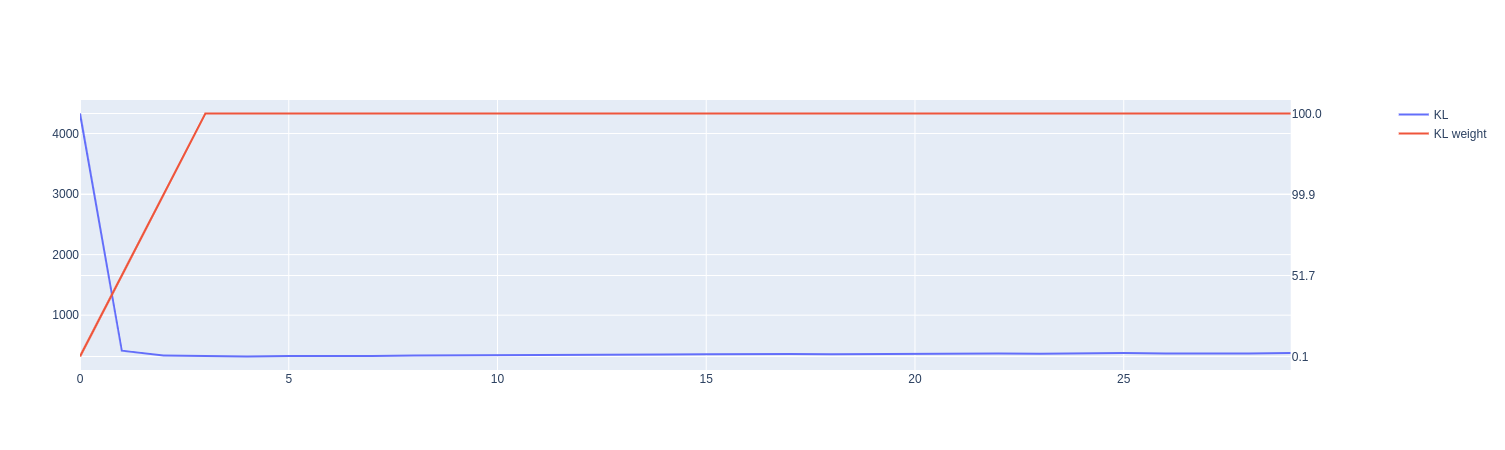

In [145]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

epochs = list(range(len(train_loss)))
iter_steps = list(range(0, 106050, 3535))
kld_weights = ['{:.1f}'.format(kld_coef(i)*100) for i in iter_steps]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=epochs, y=train_kld_loss, mode='lines', name="KL"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=epochs, y=kld_weights, mode='lines', name="KL weight"),
    secondary_y=True,
)

fig.show()

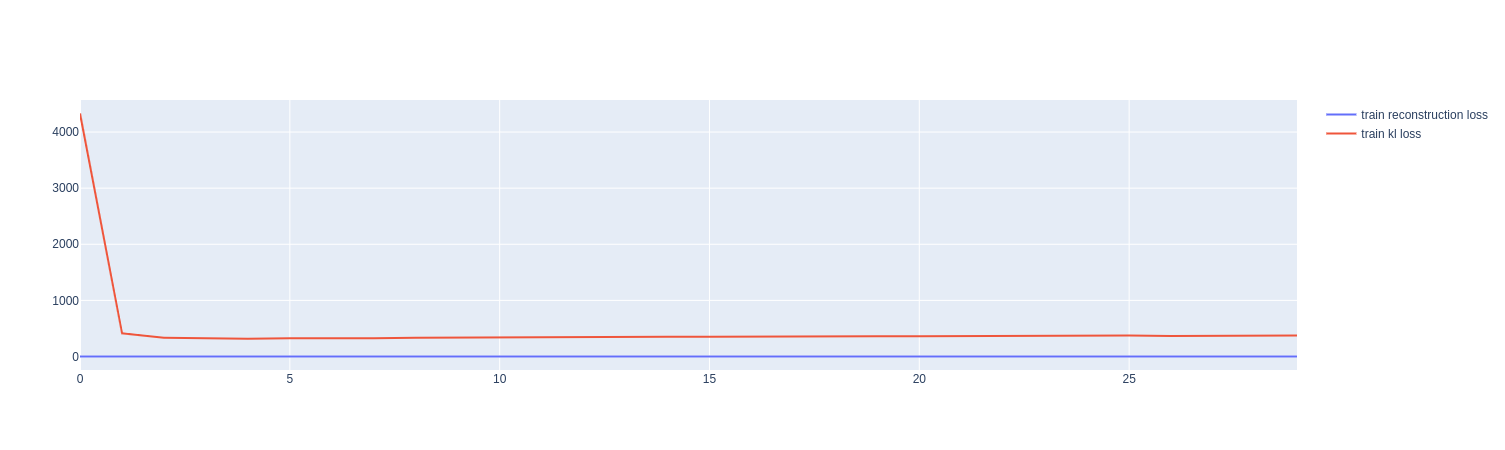

In [136]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=epochs, y=train_recon_loss,
                    mode='lines',
                    name='train reconstruction loss'))
fig.add_trace(go.Scatter(x=epochs, y=train_kld_loss,
                    mode='lines',
                    name='train kl loss'))

fig.show()

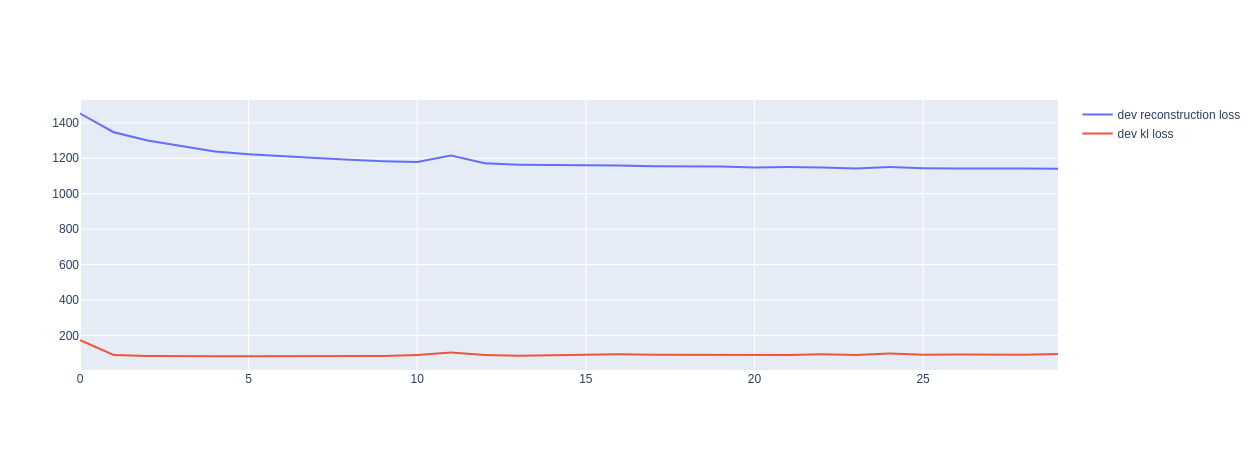

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=dev_recon_loss,
                    mode='lines',
                    name='dev reconstruction loss'))
fig.add_trace(go.Scatter(x=epochs, y=dev_kld_loss,
                    mode='lines',
                    name='dev kl loss'))

fig.show()

## Evaluate

In [13]:
vocab_size = tokenizer.get_vocab_size()

In [14]:
model = VAE(vocab_size=tokenizer.get_vocab_size(), embed_size=300, encoder_hidden_size=100, decoder_hidden_size=800,
            dropout_rate=0.5, latent_size=1000, encoder_num_layers=1, decoder_num_layers=1, word_dropout=0.5, 
            sos_idx=tokenizer.token_to_id("[SOS]"), unk_idx=tokenizer.token_to_id("[UNK]"), pad_idx=tokenizer.token_to_id("[PAD]"))
model.load_state_dict(torch.load('vae_model'))
model.to(device)
model.eval()

VAE(
  (embedding): Embedding(30000, 300, padding_idx=0)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (highway): Highway()
  (encoder): LSTM(300, 100, batch_first=True, bidirectional=True)
  (decoder): LSTM(1300, 800, batch_first=True)
  (mu): Linear(in_features=200, out_features=1000, bias=True)
  (logvar): Linear(in_features=200, out_features=1000, bias=True)
  (fc): Linear(in_features=800, out_features=30000, bias=True)
)

In [18]:
train_recon_loss = np.load('recon_losses/train_recon_loss.npy')
dev_recon_loss = np.load('recon_losses/dev_recon_loss.npy')
test_recon_loss = np.load('recon_losses/test_recon_loss.npy')
test_recon_loss_2 = np.load('recon_losses/test_recon_loss_2.npy')

In [68]:
test_recon_benign_loss = np.array([loss for i, loss in enumerate(test_recon_loss) if test_dataset[i][1] == 0])
test_recon_phish_loss = np.array([loss for i, loss in enumerate(test_recon_loss) if test_dataset[i][1] == 1])
test_recon_benign_loss_2 = np.array([loss for i, loss in enumerate(test_recon_loss_2) if test_dataset_2[i][1] == 0])
test_recon_phish_loss_2 = np.array([loss for i, loss in enumerate(test_recon_loss_2) if test_dataset_2[i][1] == 1])

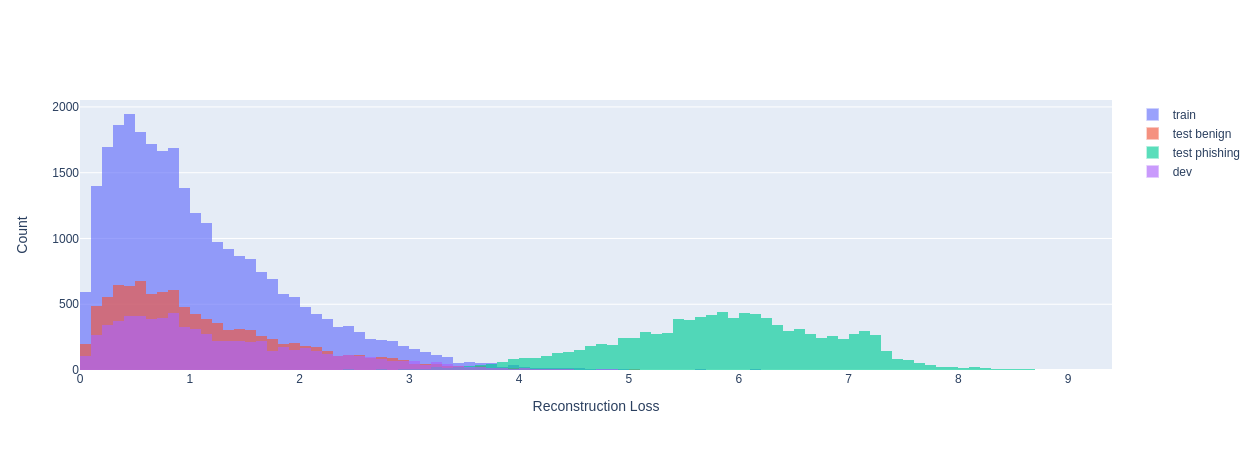

In [134]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=np.array(train_recon_loss), name='train',
                           xbins=dict(start=0, size=0.1), histnorm=''))
fig.add_trace(go.Histogram(x=np.array(test_recon_benign_loss), name='test benign', xbins=dict(start=0, size=0.1), histnorm=''))
fig.add_trace(go.Histogram(x=np.array(test_recon_phish_loss), name='test phishing', xbins=dict(start=0, size=0.1), histnorm=''))
fig.add_trace(go.Histogram(x=np.array(dev_recon_loss), name='dev',  xbins=dict(start=0, size=0.1), histnorm=''))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.65)

fig.update_layout(
    xaxis_title_text='Reconstruction Loss', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [24]:
np.percentile(train_recon_loss, 95), np.percentile(dev_recon_loss, 95)

(2.7640456795692443, 3.076470279693602)

In [150]:
np.mean(train_score) - (np.std(train_score)*3)

-2.579950211156675

In [40]:
from sklearn.neighbors import KernelDensity
kd = KernelDensity()
kd.fit(train_recon_loss.reshape(-1, 1))

KernelDensity()

In [69]:
train_score = kd.score_samples(train_recon_loss.reshape(-1, 1))
dev_score = kd.score_samples(dev_recon_loss.reshape(-1, 1))
test_benign_score_1 = kd.score_samples(test_recon_benign_loss.reshape(-1, 1))
test_phish_score_1 = kd.score_samples(test_recon_phish_loss.reshape(-1, 1))
test_benign_score_2 = kd.score_samples(test_recon_benign_loss_2.reshape(-1, 1))
test_phish_score_2 = kd.score_samples(test_recon_phish_loss_2.reshape(-1, 1))

In [50]:
def extremities(array, pct):
    # assert 50 <= pct <= 100
    return np.percentile(array, [100 - pct, pct])

In [123]:
limit_1, limit_2 = extremities(train_score, 97.5)

In [124]:
limit_1, limit_2

(-2.5098709158298447, -1.1465210314789633)

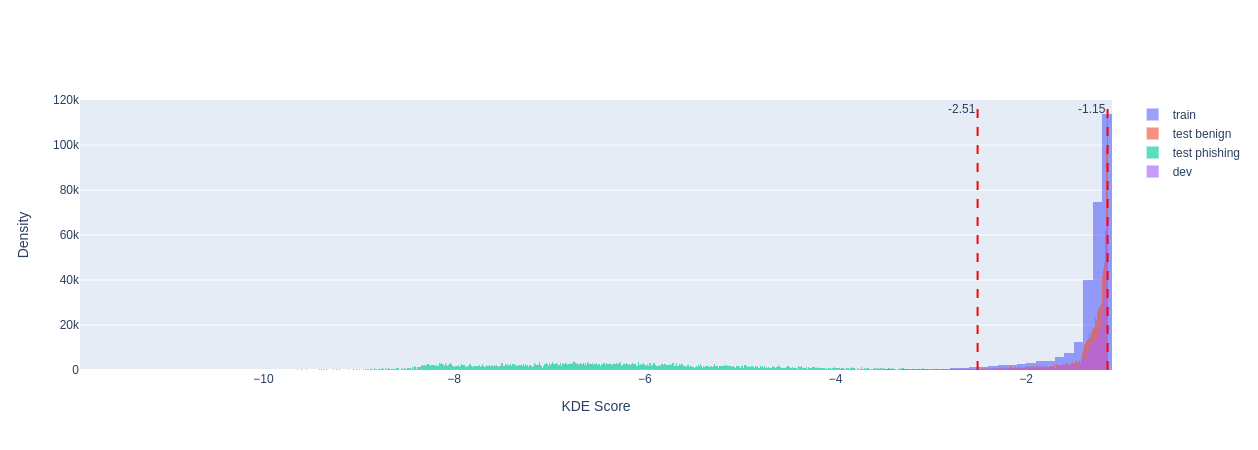

In [98]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=train_score, name='train',
                           xbins=dict(size=0.1), histnorm='density'))
fig.add_trace(go.Histogram(x=test_benign_score_1, name='test benign', xbins=dict(size=0.01), histnorm='density'))
fig.add_trace(go.Histogram(x=test_phish_score_1, name='test phishing', xbins=dict(size=0.01), histnorm='density'))
fig.add_trace(go.Histogram(x=dev_score, name='dev',  xbins=dict(size=0.01), histnorm='density'))

fig.add_vline(x=limit_1, line_dash="dash", line_color="red", annotation_text=('{:.2f}'.format(limit_1)), annotation_position="top left")
fig.add_vline(x=limit_2, line_dash="dash", line_color="red", annotation_text=('{:.2f}'.format(limit_2)), annotation_position="top left")

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.65)

fig.update_layout(
    xaxis_title_text='KDE Score', # xaxis label
    yaxis_title_text='Density', # yaxis label
)
fig.show()

In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc

def compute_metrics(preds, labels):
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
#         'auc': auc(labels, preds)
    }

def predict(scores, limit_1, limit_2):
    preds = []
    for s in scores:
        if s < limit_1 or s > limit_2:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [130]:
test_score_1 = np.concatenate((test_benign_score_1, test_phish_score_1))
test_label_1 = np.concatenate(([0]*len(test_benign_score_1), [1]*len(test_phish_score_1)))
test_score_2 = np.concatenate((test_benign_score_2, test_phish_score_2))
test_label_2 = np.concatenate(([0]*len(test_benign_score_2), [1]*len(test_phish_score_2)))

In [131]:
test_preds_1 = predict(test_score_1, limit_1, limit_2)
test_preds_2 = predict(test_score_2, limit_1, limit_2)

In [132]:
compute_metrics(test_preds_1, test_label_1)

{'accuracy': 0.9719191110221244,
 'precision': 0.9499521531100479,
 'recall': 0.9961866532865028,
 'f1': 0.9725202057310801}

In [133]:
compute_metrics(test_preds_2, test_label_2)

{'accuracy': 0.31859744971901033,
 'precision': 0.3759348252623198,
 'recall': 0.5519811281366123,
 'f1': 0.4472580263202409}

In [73]:
count = 0
for idx in np.where(test_recon_loss > 0.7)[0]:
    if test_labels[idx] == 1:
        count += 1

In [52]:
len([x for x in test_labels if x ==1])

47902

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')